In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
# Pickle in Python is primarily used in serializing and deserializing a Python object structure
# It's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.
import pickle
import pandas as pd
import random
import requests
from PIL import Image

In [4]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'],train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'],val_data['labels']

In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "Number of images not equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "Number of images not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "Number of images not equal to number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of images are not 32x32x3"

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

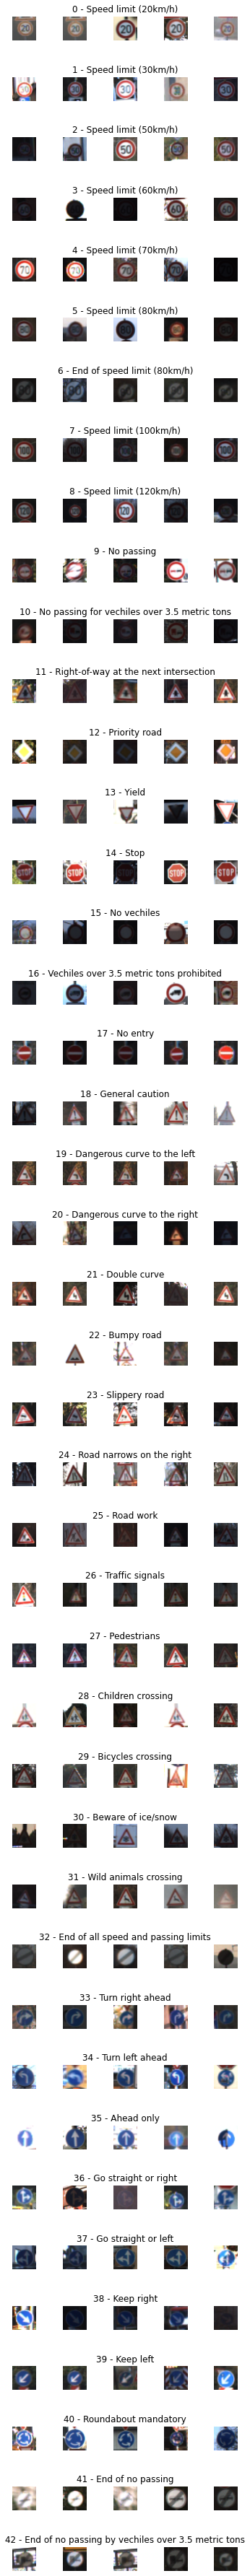

In [8]:
num_of_samples=[]
 
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

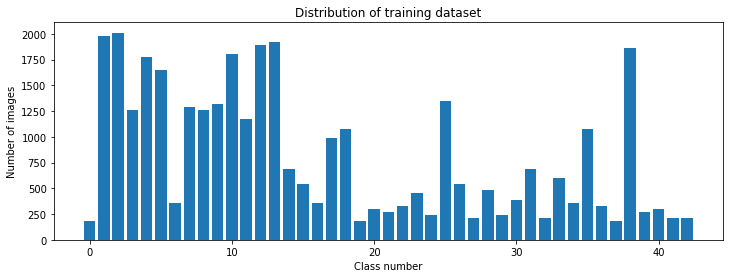

In [9]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


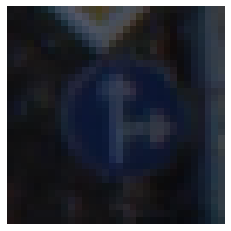

In [10]:
import cv2
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


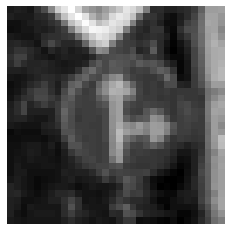

In [11]:
def grayscale(img):
  # converts img from rgb to grayscale
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

(-0.5, 31.5, 31.5, -0.5)

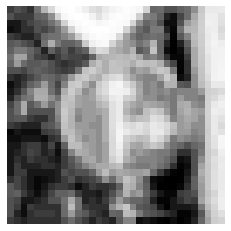

In [12]:
def equalize(img):
  # equalizeHist() will only accept grayscale images
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')

In [13]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

In [14]:
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


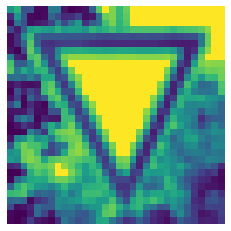

In [15]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

In [16]:
# need to add depth since this is what CNNs need
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410,32,32,1)

In [17]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

(15, 32, 32, 1)


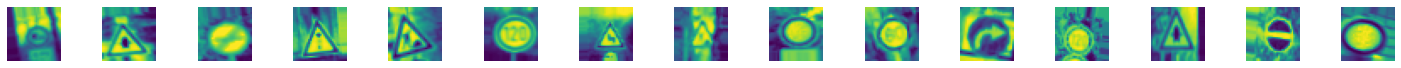

In [18]:
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [20]:
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)
y_test = to_categorical(y_test,43)

In [21]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(60,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [22]:
model = leNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 dropout (Dropout)           (None, 28, 28, 60)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 60)        32460     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 30)        16230     
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 30)        0         
                                                        

In [23]:
# history = model.fit(X_train,y_train,epochs=20,validation_data=(X_val,y_val), batch_size=400,verbose=1,shuffle=1)
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=695,
                              epochs=10,
                              validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10


<ipython-input-23-c75b8484361d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


695/695 [==============================] - 23s 21ms/step - loss: 2.0262 - accuracy: 0.4252 - val_loss: 0.4483 - val_accuracy: 0.8769
Epoch 2/10
695/695 [==============================] - 14s 21ms/step - loss: 0.7682 - accuracy: 0.7614 - val_loss: 0.1981 - val_accuracy: 0.9354
Epoch 3/10
695/695 [==============================] - 16s 23ms/step - loss: 0.4937 - accuracy: 0.8476 - val_loss: 0.1163 - val_accuracy: 0.9628
Epoch 4/10
695/695 [==============================] - 14s 21ms/step - loss: 0.3702 - accuracy: 0.8822 - val_loss: 0.1115 - val_accuracy: 0.9664
Epoch 5/10
695/695 [==============================] - 14s 21ms/step - loss: 0.3001 - accuracy: 0.9053 - val_loss: 0.0685 - val_accuracy: 0.9789
Epoch 6/10
695/695 [==============================] - 14s 20ms/step - loss: 0.2526 - accuracy: 0.9202 - val_loss: 0.0665 - val_accuracy: 0.9819
Epoch 7/10
695/695 [==============================] - 14s 20ms/step - loss: 0.2223 - accuracy: 0.9287 - val_loss: 0.0557 - val_accuracy: 0.9857
Epo

Text(0.5, 0, 'epoch')

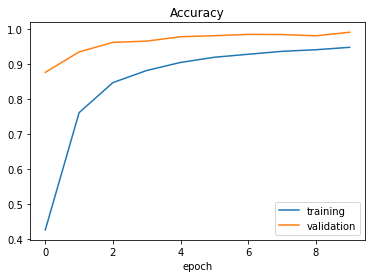

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

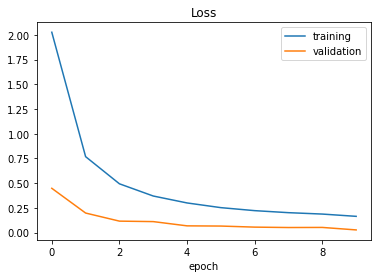

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [26]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test score:',score[0])
print('Test accuracy:',score[1])

Test score: 0.1035163477063179
Test accuracy: 0.9699921011924744


In [27]:
def test_image(model,url,expected_score):
  # fetch image
  r = requests.get(url, stream=True)
  img = Image.open(r.raw)
  plt.imshow(img, cmap=plt.get_cmap('gray'))
 
  #Preprocess image
  img = np.asarray(img)
  img = cv2.resize(img, (32, 32))
  img = preprocessing(img)
  plt.imshow(img, cmap = plt.get_cmap('gray'))

  #Reshape image
  img = img.reshape(1, 32, 32, 1)
  
  #Test image
  print("correct sign: "+ str(expected_score)+ " predicted sign: " + str(np.argmax(model.predict(img), axis =-1)))


1/1 [==============================] - 0s 158ms/step
correct sign: 1 predicted sign: [1]
1/1 [==============================] - 0s 14ms/step
correct sign: 34 predicted sign: [34]
1/1 [==============================] - 0s 21ms/step
correct sign: 23 predicted sign: [23]
1/1 [==============================] - 0s 15ms/step
correct sign: 13 predicted sign: [13]
1/1 [==============================] - 0s 15ms/step
correct sign: 29 predicted sign: [29]


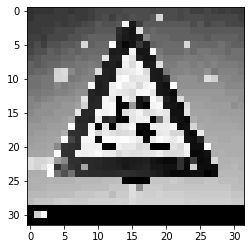

In [28]:
test_image(model,
"https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg",1)
test_image(model,"https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg",34)
test_image(model,"https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg",23)
test_image(model,"https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg",13)
test_image(model,"https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg",29)